# Finding Similar Cities in São Paulo State of Brazil
### Applied Data Science Capstone by IBM/Coursera

## Table of contents

1. [Introduction: Business Problem](#introduction)<br>
2. [Data](#data)<br>
    2.1. [Data Scraping](#scraping)<br>
    2.2. [Geographical Position from a Python Module](#position)<br>
    2.3. [Data Retrieving from API](#retrieving)<br>
3. [Methodology](#methodology)<br>
4. [Analysis](#analysis)<br>
    4.1. [Building Best Cities' Profile](#profile)<br>
    4.2. [Exploring Best K Value for Clustering](#bestk)<br>
    4.3. [Visualizing Final Result](#result)<br>
5. [Results and Discussion](#discussion)<br>
6. [Conclusion](#conclusion)<br>



## 1. Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to find similar cities in the state of **São Paulo (Brazil)**. This report can be useful to stakeholders own an establishment and wants to expand it to other similar cities that still have few or no venues of the same category, or to someone else who needs to move to another city, but keeping accessibility to venues available at his current city.

It is common, at least here in Brazil, to have every kind of establishments in big cities, but miss some categories of establishments in smaller cities, so, they could be great opportunities to endeavor. Thus, the goal of this project is to **detect similar cities in terms of their population and their most common venue categories**.

Using data science powers, we will segment and cluster cities based on the criteria above. The similar cities will be shown on maps, and the features that distinguish each cluster will then be clearly expressed through distribution plots so the stakeholders can easily aim the right city(ies).

## 2. Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* list of cities in SP state;
* number of habitants of the city;
* each city's geographical position in latitude and longitude;
* number of existing venue categories in the city.

Following, data sources will be needed to extract/generate the required information:
* the list of all cities within state of São Paulo (Brazil) will be scraped from [**Wikipedia**](https://pt.wikipedia.org/wiki/Lista_de_mesorregi%C3%B5es_e_microrregi%C3%B5es_de_S%C3%A3o_Paulo);
* the population of each city will be scraped from [**Wikipedia**](https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o);
* the geographical position of each city will be obtained using the module [**GeoPy**](https://geopy.readthedocs.io/en/stable/).
* the venues and their categories will be obtained using [**Foursquare API**](https://developer.foursquare.com/).


### 2.1. Data scraping and cleaning <a name="scraping"></a>

First of all, we will scrape list of all cities in São Paulo (SP) state available in [**Wikipedia**](https://pt.wikipedia.org/wiki/Lista_de_mesorregi%C3%B5es_e_microrregi%C3%B5es_de_S%C3%A3o_Paulo).

In [1]:
# Importing necessary modules
# -*- coding: utf-8 -*-
import sys
import pandas as pd
#from bs4 import BeautifulSoup
import numpy as np
import requests
import json
import folium  # map rendering module
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

coding = sys.stdout.encoding

In [4]:
# The URL which hospedates all information of SP cities.
url = 'https://pt.wikipedia.org/wiki/Lista_de_mesorregi%C3%B5es_e_microrregi%C3%B5es_de_S%C3%A3o_Paulo'
# Read all tables within site.
table_list = pd.read_html(url)

# Mesoregions of SP state are on first table of the site
mesoregions_df = table_list[0]

mesoregions_df.head(3)

,Mesorregião[1][2],Código,Número de municípios,Localização,Microrregiões,Código.1
0,São José do Rio Preto,1,109,NaN,Jales,1
1,São José do Rio Preto,1,109,NaN,Fernandópolis,2
2,São José do Rio Preto,1,109,NaN,Votuporanga,3


On the mesoregion table, there are some irrelevant data: "Código", "Número de municípios", "Loalização", "Código.1" (from portuguese means "Code", "Number of cities", "Localization", "Code.1").
After collecting all tables, we will clean these unecessary data from this table.

In [5]:
# Microregions of SP state are on all the rest of tables of the site
microregions_df = table_list[1]
microregions_len = microregions_df.shape[0]
for i in range(2,len(table_list)-1):
    microregions_df = microregions_df.append(table_list[i], ignore_index=True)
    microregions_len += table_list[i].shape[0]

microregions_df.head(3)

,Microrregião[1][2],Código,Localização,Municípios
0,Jales,1,NaN,Aparecida d'Oeste
1,Jales,1,NaN,Aspásia
2,Jales,1,NaN,Dirce Reis


Like the mesoregion table, there are irrelevant data for us on Microregion table: "Código", "Localização" (from portuguese means "Code", "Localization").

Now we have collected the raw data, **let's clean them**.

In [6]:
# Droping unecessary features from Mesoregion dataframe.
mesoregions_df.drop(columns=['Código', 'Número de municípios', 'Localização', 'Código.1'], inplace=True)
# Renaming columns with English terms.
mesoregions_df.columns = ['Mesoregion', 'Microregion']
mesoregions_df.head(3)

,Mesoregion,Microregion
0,São José do Rio Preto,Jales
1,São José do Rio Preto,Fernandópolis
2,São José do Rio Preto,Votuporanga


In [7]:
# Droping unecessary features from Microregions dataframe.
microregions_df.drop(columns=['Código', 'Localização'], inplace=True)
# Renaming columns with English terms.
microregions_df.columns = ['Microregion', 'City']
microregions_df.head(3)

,Microregion,City
0,Jales,Aparecida d'Oeste
1,Jales,Aspásia
2,Jales,Dirce Reis


Now, let's merge both dataframes based on "Microregion" feature.

In [8]:
# Merging mesoregions with microregions into one dataframe.
cities_df = mesoregions_df.merge(microregions_df, left_on='Microregion', right_on='Microregion')
print("Shape of cities_df: ", cities_df.shape)
cities_df.head(3)

Shape of cities_df:  (645, 3)


,Mesoregion,Microregion,City
0,São José do Rio Preto,Jales,Aparecida d'Oeste
1,São José do Rio Preto,Jales,Aspásia
2,São José do Rio Preto,Jales,Dirce Reis


Now we have the dataframe containing all regions and cities of SP state, **let's collect the population of each city** from [**Wikipedia**](https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o).

In [9]:
# The Wikipedia URL with population information of SP state.
population_url = 'https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o'
# Collect population data from table within site.
population_list = pd.read_html(population_url)
population_df = population_list[0]

population_df.head(3)

,Posição,Código IBGE,Município,Unidade federativa,População
0,1º,3550308,São Paulo,São Paulo,12252023
1,2º,3304557,Rio de Janeiro,Rio de Janeiro,6718903
2,3º,5300108,Brasília,Distrito Federal,3015268


The raw dataframe collected contains some irrelevant features for our study case: "Posição", "Código IBGE", "Unidade federativa" (from portuguese they mean "Ranking", "IBGE Code", "Federative Unit"). 
Also, this table contains population from all Brazilian cities, so we need to filter by "Unidade federativa", which is the state in which each city belongs to, considering only São Paulo.

Thus, **let's get rid of these unecessary instances and columns**, and rename the relevant feature in English terms.

In [10]:
# Drop all instance are note from SP state.
popsp_df = population_df[population_df['Unidade federativa'] == 'São Paulo'].iloc[:,2:].reset_index(drop=True)
# Drop all unecessary features.
popsp_df.drop(columns=['Unidade federativa'], inplace=True)
# Rename columns with English terms.
popsp_df.columns = ['City', 'Population']
popsp_df.head(3)

,City,Population
0,São Paulo,12252023
1,Guarulhos,1379182
2,Campinas,1204073


Finally, **let's merge the region-cities and cities-population dataframes** into one dataframe.

In [11]:
# merging city geographical information with population
spcities_df = cities_df.merge(popsp_df, left_on='City', right_on='City')
spcities_df.head(3)

,Mesoregion,Microregion,City,Population
0,São José do Rio Preto,Jales,Aparecida d'Oeste,4196
1,São José do Rio Preto,Jales,Aspásia,1822
2,São José do Rio Preto,Jales,Dirce Reis,1793


### 2.2. Geographical Position from a Python Module <a name="position"></a>

Now we have all SP state's cities and their respective population, **let's collect their respective geographical position** using the **module** [**GeoPy**](https://geopy.readthedocs.io/en/stable/).

With this module, it is possible to easily retrieve the geographical location given an address or, in this case, the city name and its state and country.

In [191]:
# Importing Nominatim
from geopy.geocoders import Nominatim

In [13]:
# Define agent to request position coordinates.
geolocator = Nominatim(user_agent='it_is_me')

# Retrieving each city's geographical coordinates.
longitude = []
latitude = []
i=0
for city in spcities_df['City']:
    city = city + ', SP'
    
    location = geolocator.geocode(city)
    longitude.append(location.longitude)
    latitude.append(location.latitude)
    i+=1
    # print("{}/{}".format(i, spcities_df.shape[0]))

# Adding the obtained coordinates into sp_cities dataframe
spcities_df['Longitude'] = longitude
spcities_df['Latitude'] = latitude

#spcities_df = pd.read_csv('0_saopaulo_cities.csv', index_col=0)
print("Shape of spcities_df: ", spcities_df.shape)
spcities_df.head(3)

Shape of spcities_df:  (643, 6)


,Mesoregion,Microregion,City,Population,Longitude,Latitude
0,São José do Rio Preto,Jales,Aparecida d'Oeste,4196,-50.880871,-20.449811
1,São José do Rio Preto,Jales,Aspásia,1822,-50.728046,-20.160028
2,São José do Rio Preto,Jales,Dirce Reis,1793,-50.606276,-20.466407


Let's **visualize these cities on map**, using the [Folium](https://python-visualization.github.io/folium/) module.

In [14]:
# Collecting state of São Paulo coordinates
geolocator = Nominatim(user_agent='it_is_me')
saopaulo = geolocator.geocode('São Paulo, Brazil')
# adjusting for better visualization
latitude, longitude = (saopaulo.latitude+1, saopaulo.longitude-1)

# Create map of São Paulo using latitude and longitude values
map_sp = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
max_population = spcities_df['Population'].max()
for lat, lng, population, city in zip(spcities_df['Latitude'], spcities_df['Longitude'], spcities_df['Population'], spcities_df['City']):
    label = '{}, {}'.format(city, population)
    label = folium.Popup(label, parse_html=True, max_width=100)
    if(city != 'São Paulo'):
        rad = 6*(population/1370000)
    else:
        rad = 7    
    folium.CircleMarker(
        [lat, lng],
        radius=rad,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sp)  
    
map_sp

### 2.3. Data Retrieving from API <a name="retrieving"></a>

Next, with help of [**Foursquare API**](https://developer.foursquare.com/), let's explore and segment the cities in SP state!

Basically, **Foursquare** provide an API to easily explore venues, given a geographical location (latitude and longitude) and a radius, among other interesting features.

Before start using the API, it is necessary to sign up to Foursquare to get the necessary credentials. All steps can be read on Foursquare [_Get Started_](https://developer.foursquare.com/docs/places-api/getting-started/) tutorial.

In [17]:
# Declare your credentials to request data from Foursquare
CLIENT_ID = 'YOUR_ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR_CLIENT_SECRET' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
ACCESS_TOKEN = 'YOUR_ACCESS_TOKEN' # your access token

When exploring venues with Foursquare API, the raw data retrieved is given in the JSON standard. So, to make it faster and get a pandas dataframe with the willed data, **let's define a function to parse the raw data to return a dataframe with the available venues**, given the city, its geographical coordinates, radius of research and the limit of venues to be retrieved.

In [18]:
# Function to request the list of venues from Foursquare API, and parse the json raw data into a pandas dataframe.
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    counter = 1
    max_city = len(names)
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(counter, '/', max_city, " ", name)
        counter+=1
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            
            #print(name)
        except:
            venues_list.append([
                name, 
                lat, 
                lng, 
                '', 
                np.nan, 
                np.nan,  
                ''])
            
            #print("No venue found at " + name)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, we can just call this function, giving the list (in pandas Series) with all cities, their respective coordinates, the radius of exploration (in this case 5 km), and limit of venues to be retrieved (in this case, set to 200).

>P.S.: The radius and limit values were defined empiracally. Using distance measurement tool from Google Earth, I estimated the average radius of cities in SP state, measured from the center of the city.

In [ ]:
saopaulo_venues = getNearbyVenues(names=spcities_df['City'],
                                 latitudes=spcities_df['Latitude'],
                                 longitudes=spcities_df['Longitude'],
                                 radius=5000,
                                 LIMIT=200)

In [3]:
#saopaulo_venues.to_csv('1_saopaulo_venues.csv')
saopaulo_venues = pd.read_csv('1_saopaulo_venues.csv', index_col=0)
print("Shape of saopaulo_venues: ", saopaulo_venues.shape)
saopaulo_venues.head(3)

Shape of saopaulo_venues:  (14757, 7)


,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aparecida d'Oeste,-20.449811,-50.880871,Farmácia do Pedro,-20.451159,-50.881847,Pharmacy
1,Aparecida d'Oeste,-20.449811,-50.880871,Bar do Fabião,-20.450060,-50.886469,African Restaurant
2,Dirce Reis,-20.466407,-50.606276,Padaria Doce Pao,-20.464830,-50.606962,Bakery


Let's see how many unique venue categories there are in this retrieved data.

In [4]:
print("There are {} different categories!".format(len(saopaulo_venues['Venue Category'].unique())))

There are 392 different categories!


## 3. Methodology <a name="methodology"></a>

This project focuses on segmenting and clustering cities of São Paulo state (Brazil), based on the kinds of venues available in each city, and its population.  
To facilitate the understanding of this project methodology, I will divide it into 3 main parts: data acquisition and cleaning, exploratory data analysis, and predictive modeling.

First of all, we have collected the required data (list of São Paulo state's cities, their geographical coordinates, their population, and list of venues in each city) from different sources. The list of cities and their respective population we have extracted from Wikepedia using the method `read_html()` from **Pandas** module, since these data are exposed on tables on the website. For the geographical coordinates, we used **GeoPy** module, since we already have the list of cities. And to list the venues in each city, we used the **Foursquare API**, since we now have each city's geographical coordinates.

Second part is the exploratory data analysis. In this step we will explore not only the main categories (most frequent) in each city, but also consider the number of habitants by calculating the rate of number of a venue category to the population. With this analysis, we can have a notion of how full can a venue be. For example, if a city of 100 thousand habitants has just 2 japanese restaurants, probably there will be much more demand than offert of japanese food in this city. Moreover, we will explore the best `K` value for better clustering of cities using the **K-Means** clustering technique, and data visualization.
For this step, we will use, mainly, the **Pandas**, **Scikit-Learn**, **Folium**, **Matplotlib**, and **Seaborn** modules.

Once we have pre-processed the data, found the best features and number of clusters, in the third and final part, we will generate the model for final clustering using **Scikit-Learn** module, and show the result in map using **Folium**.

## 4. Analysis <a name="analysis"></a>

### 4.1. Building best cities' profile <a name="profile"></a>

Since categorical variable cannot be processed in some algorithms, like clustering algorithms we will use soon, we must **transform each category into a binary variable**. One method does that is [**One-hot-enconding**](https://en.wikipedia.org/wiki/One-hot).

In [6]:
# one hot encoding
saopaulo_onehot = pd.get_dummies(saopaulo_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
saopaulo_onehot['City'] = saopaulo_venues['City'] 

# move City column to the first column
fixed_columns = [saopaulo_onehot.columns[-1]] + list(saopaulo_onehot.columns[:-1])
saopaulo_onehot = saopaulo_onehot[fixed_columns]

#saopaulo_onehot.to_csv('2_saopaulo_onehot.csv')
print('saopaulo_onehot.shape: ', saopaulo_onehot.shape)
saopaulo_onehot.head(3)

saopaulo_onehot.shape:  (14757, 392)


,Zoo Exhibit,ATM,Acai House,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
categories_list = list(saopaulo_onehot.columns)
categories_list.sort()
categories_list

['ATM',
 'Acai House',
 'Accessories Store',
 'Adult Boutique',
 'African Restaurant',
 'Airport',
 'Airport Lounge',
 'Airport Terminal',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Athletics & Sports',
 'Australian Restaurant',
 'Auto Dealership',
 'Auto Garage',
 'Auto Workshop',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Bath House',
 'Bathing Area',
 'Beach',
 'Beach Bar',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Garden',
 'Beer Store',
 'Big Box Store',
 'Bike Trail',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Border Crossing',
 'Botanical Garden',
 'Boutique',
 'Bowling Alley',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bridge',
 'Buffet',
 'Building',
 'Bu

With this, we now have 392 different categories, among which there are many similars that could be joined, like "Art Gallery" and "Art Museum", or "Bar" and "Beer bar".

So, **let's join these similar categories** based on key words within each category string.

In [7]:
# List and sort all categories
columns = list(saopaulo_onehot.columns)
columns.remove('City')
columns.sort()

# New categories dataframe
spcities_onehot = pd.DataFrame()

# Finding similar categories, by finding similar words, to merge them
for col in columns:
    spcities_onehot[col] = saopaulo_onehot[col]
    key = col.split(' ')[0]
    matching = [s for s in columns if (key) in s]
    for i in range (1, len(matching)):
        spcities_onehot[col] += saopaulo_onehot[matching[i]]
        columns.remove(matching[i])

spcities_onehot.insert(0, 'City', saopaulo_onehot['City'])
#spcities_onehot.to_csv('3_spcities_onehot.csv')
print("spcities_onehot.shape: ", spcities_onehot.shape)
spcities_onehot.head(3)

spcities_onehot.shape:  (14757, 229)


,City,ATM,Acai House,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,...,Volleyball Court,Warehouse Store,Watch Shop,Waterfall,Waterfront,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Aparecida d'Oeste,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aparecida d'Oeste,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dirce Reis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
spcities_onehot.sum()

City                 Aparecida d'OesteAparecida d'OesteDirce ReisDo...
ATM                                                                  1
Acai House                                                          46
Accessories Store                                                    4
Adult Boutique                                                       1
                                           ...                        
Wine Shop                                                           27
Wings Joint                                                          3
Women's Store                                                        8
Yoga Studio                                                          2
Zoo                                                                 13
Length: 229, dtype: object

From 392, we have 229 different categories. 
But when it comes to clustering problem, we must find the features that best distinguishes each cluster. 
We can see there are many features with too few occurences, which won't differentiate cities well, and features with too much occurences, which also does not differentiate cities, because probably most of them have this kind of establishment.

Following this reason, **let's now drop some features by their quantity of occurences**. Please, note that the number used as threshold for selecting the features were set empirically.

In [139]:
spcities_df.shape

(643, 6)

In [170]:
# Eliminate categories with too few or too much occurences.
cols = list(spcities_onehot.columns)
cols.remove('City')
categories_counter = spcities_onehot[cols].sum()
maximum = categories_counter.max()
upthreshold = maximum // 2
downthreshold = 150 #spcities_df.shape[0] // 2
categories_counter = categories_counter[categories_counter<upthreshold]  # too much means most of cities have, so it does not differenciate cities
categories_counter = categories_counter[categories_counter>downthreshold]  # too few means too few cities have it, so it also does not differenciate them
relevant_categories = list(categories_counter.index)

print('Now, there are {} relevant categories, which are: '.format(len(relevant_categories)))
print(relevant_categories)

Now, there are 23 relevant categories, which are: 
['BBQ Joint', 'Bakery', 'Bar', 'Bed & Breakfast', 'Brazilian Restaurant', 'Burger Joint', 'Café', 'Coffee Shop', 'Convenience Store', 'Dessert Shop', 'Fast Food Restaurant', 'Food', 'Grocery Store', 'Gym', 'Hot Spring', 'Ice Cream Shop', 'Italian Restaurant', 'Japanese Restaurant', 'Market', 'Park', 'Pharmacy', 'Pizza Place', 'Plaza']


In this case, now we have come to 23 features that can better differenciate clusters.

Now, we generate a **new dataframe containing the cities, their population, and these 15 most relevant features**.

In [171]:
# New dataframe containing just the relevant_categories
spcities = spcities_onehot[['City'] + relevant_categories]
spcities.to_csv('4_spcities.csv')
print("spcities.shape: ", spcities.shape)
spcities.head(3)

spcities.shape:  (14757, 24)


,City,BBQ Joint,Bakery,Bar,Bed & Breakfast,Brazilian Restaurant,Burger Joint,Café,Coffee Shop,Convenience Store,...,Gym,Hot Spring,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Pizza Place,Plaza
0,Aparecida d'Oeste,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Aparecida d'Oeste,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dirce Reis,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, **let's build the cities profiles** by grouping the list of venues (previous dataframe) by city name.

With this, we obtain each city's profile of venues (the 15 most relevant for clustering).

In [172]:
# Calculating mean frequency of occurence of each venue on each city = cities' profiles
spcities_grouped = spcities.groupby('City').mean().reset_index()
print('spcities_grouped.shape: ', spcities_grouped.shape)
spcities_grouped.head(3)

spcities_grouped.shape:  (623, 24)


,City,BBQ Joint,Bakery,Bar,Bed & Breakfast,Brazilian Restaurant,Burger Joint,Café,Coffee Shop,Convenience Store,...,Gym,Hot Spring,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Pizza Place,Plaza
0,Adamantina,0.02,0.060000,0.100000,0.0,0.04,0.04,0.02,0.0,0.020000,...,0.06,0.04,0.140000,0.0,0.04,0.040000,0.040000,0.02,0.060000,0.0
1,Adolfo,0.00,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0,0.000000,...,0.00,0.00,0.000000,0.0,0.00,0.000000,0.000000,1.00,0.000000,0.0
2,Aguaí,0.00,0.105263,0.052632,0.0,0.00,0.00,0.00,0.0,0.052632,...,0.00,0.00,0.052632,0.0,0.00,0.105263,0.105263,0.00,0.052632,0.0


Another thing we must consider is outlier. 
In this study case, São Paulo city (the capital of São Paulo state) is an outlier if compared to all other cities. Let's take a look at a scatter plot of each cities vs population on the next cell.

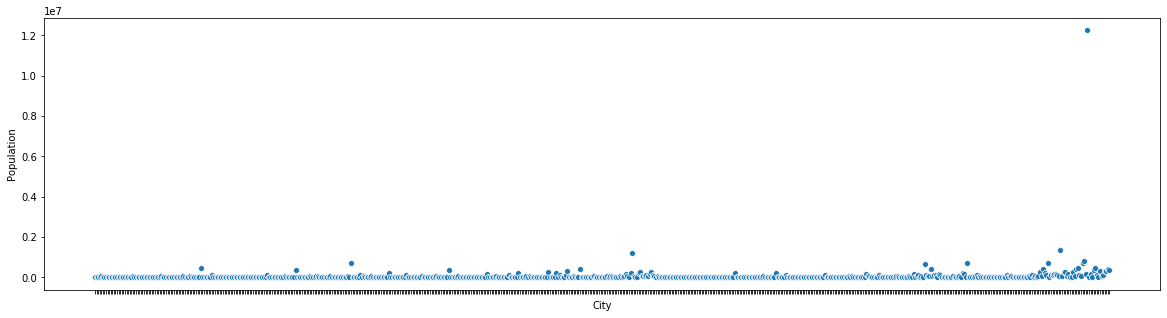

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

#spcities_df[['City', 'Population']].plot(kind='scatter')
plt.figure(figsize=(20,5))
ax = sns.scatterplot(x=spcities_df.City, y=spcities_df.Population)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.show()

Obsrerve the population of São Paulo capital is a very far from average population line. If we plot the occurences of each venue category, we will find out the capital is also an outlier. 
So, with this huge discrepancy, if we consider the capital in the process of clustering, this would distort the final result, being São Paula a big bias.

Thus, **let's drop the São Paulo city instance**, and consider it a unique case in which we can find any category of venue available.

In [174]:
# select São Paulo capital index
saopaulo_capital = spcities_grouped[spcities_grouped.City=='São Paulo'].index[0]

# delete capital's row, because it is an outlier. It is too big compared to all other cities!
spcities_grouped.drop(saopaulo_capital, axis=0, inplace=True)
spcities_grouped.shape

(622, 24)

Until now, we have two dataframes to use, the `spcities_df` with geographical coordinates and population info, and the `spcities_grouped` with cities' profile in terms of venues. 

**Let's now merge both to obtain a new cities' profile in terms of population and the venues**. 
Note population has huge nnumbers, so we will also normalize them.

In [297]:
# Merge cities' profile to population info
spcities_profile = spcities_grouped.merge(spcities_df[['City','Population']], left_on='City', right_on='City')

# Normalize Population data
min_population = spcities_profile['Population'].min()
max_population = spcities_profile['Population'].max()
print('max_population: {}; min_population: {}'.format(min_population, max_population))
spcities_profile['Population'] = (spcities_profile['Population'] - min_population)/(max_population - min_population)
cols = list(spcities_profile.columns)
cols.remove('City')
cols.remove('Population')
cols = ['City', 'Population'] + cols
spcities_profile = spcities_profile[cols]

spcities_profile.to_csv('5_spcities_profile.csv')
print("spcities_profile.shape = ", spcities_profile.shape)
spcities_profile.head(3)

max_population: 1165; min_population: 1379182
spcities_profile.shape =  (622, 25)


,City,Population,BBQ Joint,Bakery,Bar,Bed & Breakfast,Brazilian Restaurant,Burger Joint,Café,Coffee Shop,...,Gym,Hot Spring,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Pizza Place,Plaza
0,Adamantina,0.024603,0.02,0.060000,0.100000,0.0,0.04,0.04,0.02,0.0,...,0.06,0.04,0.140000,0.0,0.04,0.040000,0.040000,0.02,0.060000,0.0
1,Adolfo,0.001739,0.00,0.000000,0.000000,0.0,0.00,0.00,0.00,0.0,...,0.00,0.00,0.000000,0.0,0.00,0.000000,0.000000,1.00,0.000000,0.0
2,Aguaí,0.025500,0.00,0.105263,0.052632,0.0,0.00,0.00,0.00,0.0,...,0.00,0.00,0.052632,0.0,0.00,0.105263,0.105263,0.00,0.052632,0.0


Now, considering we want to know, not only if a city has a category of venue but also the notion of offert vs demand, **let's calculate this rate by dividing the population column by each category columns**.

In [309]:
# Calculate the rate of each venue category per habitant
venues_vs_population = spcities_profile.copy()
for i in np.arange(3, venues_vs_population.shape[1]):
    venues_vs_population.iloc[:, i] = venues_vs_population.Population.div(venues_vs_population.iloc[:, i], axis=0)

venues_vs_population.head(3)

,City,Population,BBQ Joint,Bakery,Bar,Bed & Breakfast,Brazilian Restaurant,Burger Joint,Café,Coffee Shop,...,Gym,Hot Spring,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Pizza Place,Plaza
0,Adamantina,0.024603,0.02,0.410046,0.246027,inf,0.615069,0.615069,1.230137,inf,...,0.410046,0.615069,0.175734,inf,0.615069,0.615069,0.615069,1.230137,0.410046,inf
1,Adolfo,0.001739,0.00,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,0.001739,inf,inf
2,Aguaí,0.025500,0.00,0.242254,0.484508,inf,inf,inf,inf,inf,...,inf,inf,0.484508,inf,inf,0.242254,0.242254,inf,0.484508,inf


As result, we can see there are many `inf` (infinite) values, which is expected, because if a city does not have any venue of a category, then the demand will be very high for no offer. However, we cannot consider infinite as value, so **let's replace these inf values by a big value** (higher than any result), **and normalize the resulting dataframe**.

In [310]:
# replace infinite and nan values wwith double of max value and zero, respectively
venues_vs_population.replace([np.inf, -np.inf], 200, inplace=True)
venues_vs_population.replace([np.nan, -np.nan], 0, inplace=True)

# normalize values according to column
min_profile = venues_vs_population.iloc[:, 3:].min()
max_profile = venues_vs_population.iloc[:, 3:].max()
venues_vs_population.iloc[:, 3:] = (venues_vs_population.iloc[:, 3:] - min_profile)/(max_profile - min_profile)
venues_vs_population.head(3)

,City,Population,BBQ Joint,Bakery,Bar,Bed & Breakfast,Brazilian Restaurant,Burger Joint,Café,Coffee Shop,...,Gym,Hot Spring,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Market,Park,Pharmacy,Pizza Place,Plaza
0,Adamantina,0.024603,0.02,0.002050,0.001230,1.0,0.003075,0.003075,0.006151,1.0,...,0.00205,0.003075,0.000879,1.0,0.003075,0.003075,0.003075,0.006151,0.002050,1.0
1,Adolfo,0.001739,0.00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.000009,1.000000,1.0
2,Aguaí,0.025500,0.00,0.001211,0.002423,1.0,1.000000,1.000000,1.000000,1.0,...,1.00000,1.000000,0.002423,1.0,1.000000,0.001211,0.001211,1.000000,0.002423,1.0


### 4.2. Exploring Best K Value for Clustering <a name="bestk"></a>

Now we have a good cities' profile dataframe, **let's find the best number of clusters `K`**.

In [178]:
# Import K-Means from clustering stage
from sklearn.cluster import KMeans

To test different `K` values, **we will make a for loop with `K` varying from 3 to 8** and create the K-Means models with them.

In [179]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

results_list = []
# where kcluster is number of clusters
for kclusters in np.arange(3, 9):
    spcities_clustering = venues_vs_population.drop('City', 1)

    # run K-Means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(spcities_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10]

    # add clustering labels
    result = cities_venues_sorted[['City']]
    result.insert(0, 'Cluster Labels', kmeans.labels_)

    # copy neighborhoods_df on spcities_merged
    spcities_merged = spcities_df[['City','Latitude','Longitude','Population']]

    # merge toronto neighborhoods dataframe with neighborhoods profile dataframe
    spcities_merged = spcities_merged.merge(result.set_index('City'), left_on='City', right_on='City')

    # list results
    results_list.append(spcities_merged)

    print("kcluster = {}".format(kclusters))
    print("Max cluster: {}".format(spcities_merged[['Cluster Labels']].max()))
    #print("shape of spcities_merged: ", spcities_merged.shape)
    #spcities_merged.head(3) # check first rows

results_list[:5]

kcluster = 3
Max cluster: Cluster Labels    2
dtype: int32
kcluster = 4
Max cluster: Cluster Labels    3
dtype: int32
kcluster = 5
Max cluster: Cluster Labels    4
dtype: int32
kcluster = 6
Max cluster: Cluster Labels    5
dtype: int32
kcluster = 7
Max cluster: Cluster Labels    6
dtype: int32
kcluster = 8
Max cluster: Cluster Labels    7
dtype: int32


[                  City   Latitude  Longitude  Population  Cluster Labels
 0    Aparecida d'Oeste -20.449811 -50.880871        4196               1
 1           Dirce Reis -20.466407 -50.606276        1793               1
 2         Dolcinópolis -20.123074 -50.513261        2115               1
 3                Jales -20.267177 -50.549244       49107               0
 4          Marinópolis -20.440833 -50.822778        2112               1
 ..                 ...        ...        ...         ...             ...
 617            Cubatão -23.885798 -46.424187      130705               0
 618            Guarujá -23.992777 -46.255833      320459               0
 619       Praia Grande -24.005833 -46.402778      325073               0
 620             Santos -23.960833 -46.333889      433311               0
 621        São Vicente -23.960369 -46.384702      365798               0
 
 [622 rows x 5 columns],
                   City   Latitude  Longitude  Population  Cluster Labels
 0    Apare

Now, **let's visualize each result** by plotting the distribution of features for each cluster in each.

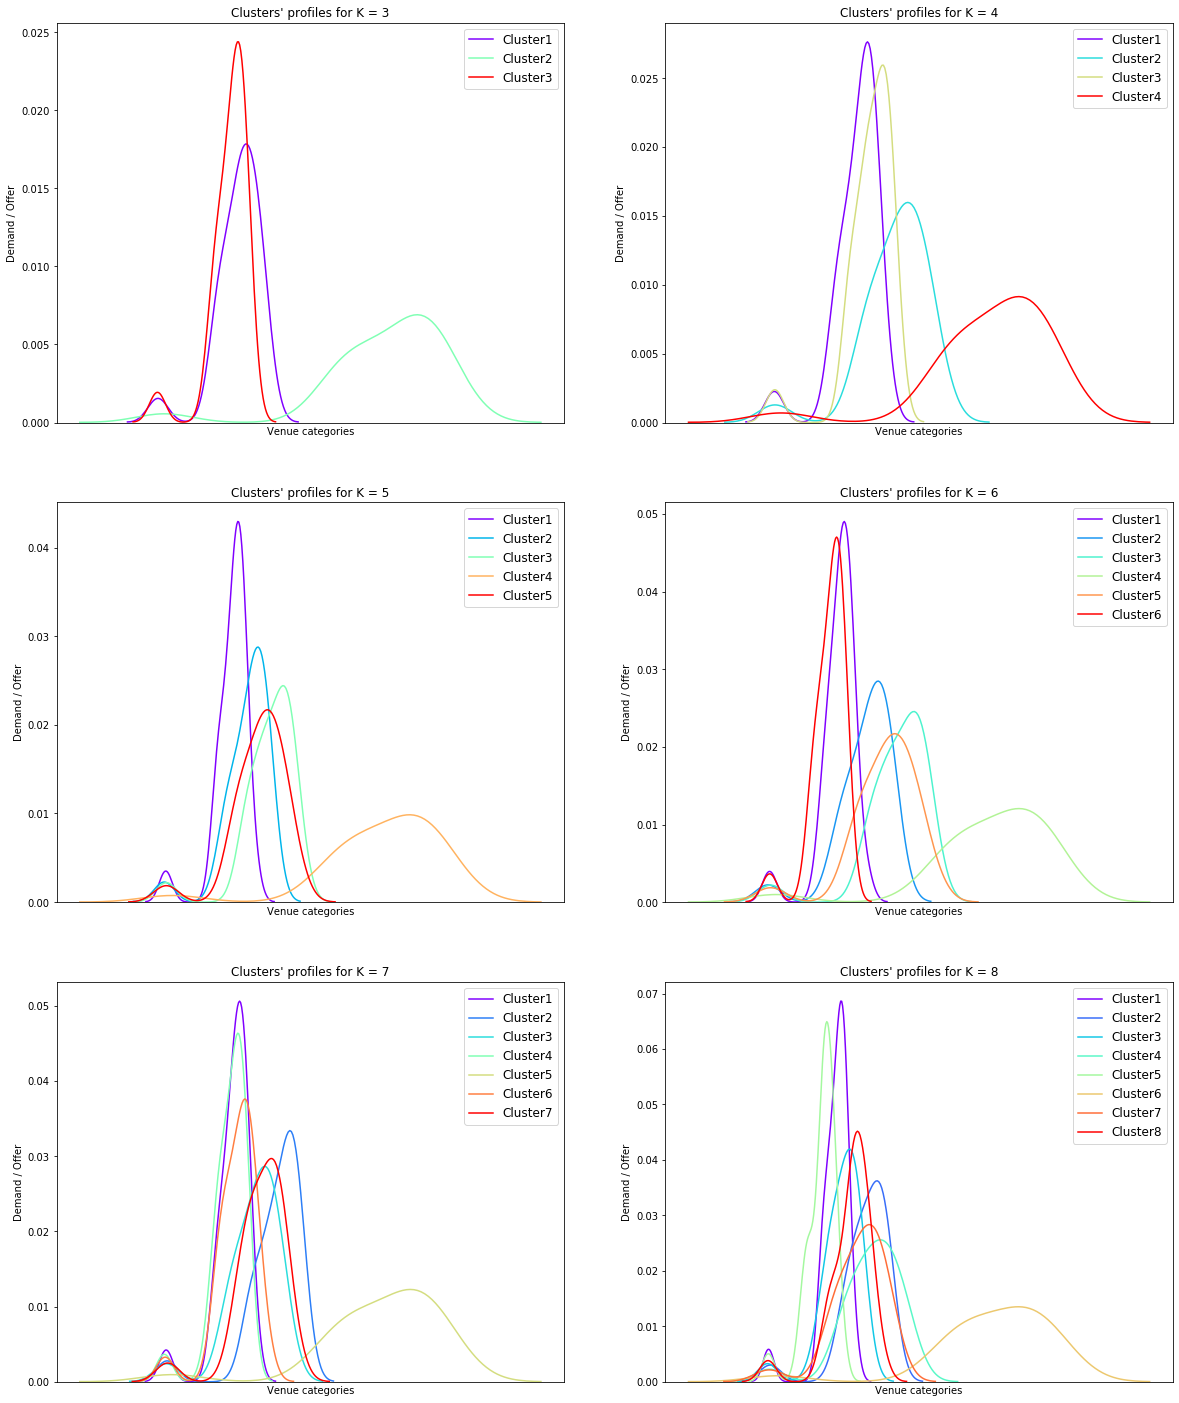

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,25))
#plt.subplots_adjust(hspace=0.5)

for kclusters in np.arange(3, 9):
    plt.subplot(32*10+(1+kclusters-3))
    spcities_clusters = results_list[kclusters-3]
    kmeans_labels = list(spcities_clusters['Cluster Labels'])

    venues_vs_population.insert(0, 'Cluster Labels', kmeans_labels)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    for i in range(kclusters):
        df = venues_vs_population[venues_vs_population['Cluster Labels'] == i]
        df_profile = df.sum()
        
        label = 'Cluster' + str(i+1)
        sns.distplot(df_profile.iloc[3:], rug=False, hist=False, kde=True, label=label, color=rainbow[i])

    # Plot formatting
    plt.legend(prop={'size': 12})
    plt.title('Clusters\' profiles for K = {}'.format(kclusters))
    plt.xlabel('Venue categories')
    plt.xticks(ticks=[])
    plt.ylabel('Demand / Offer')
    
    venues_vs_population.drop('Cluster Labels', axis=1, inplace=True)

#plt.savefig('k_tests.png')

Now, take some time to observe each of these graphs. All of them has intersecting distribution curves, but **the result that seems better separate each cluster is for `K` = 4**, i.e., the model with 4 clusters.

All the other results has almost totally overlapped curves, and the more clusters the more agglomerated are the curves.

### 4.3. Visualizing Final Result <a name="result"></a>

Finally, **let's visualize on map the obtained cities cluters** in São Paulo state.

In [192]:
# for solution with 4 clusters
kclusters=4
spcities_merged = results_list[1]

# Collecting state of São Paulo coordinates
geolocator = Nominatim(user_agent='it_is_me')
saopaulo = geolocator.geocode('São Paulo, Brazil')
# adjusting for better visualization
latitude, longitude = (saopaulo.latitude+1, saopaulo.longitude-1)

# create map
map_clusters = folium.Map(location=[latitude+0.3, longitude-0.8], zoom_start=7.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
min_population = spcities_merged['Population'].min()
for lat, lon, poi, cluster, population in zip(spcities_merged['Latitude'], spcities_merged['Longitude'], spcities_merged['City'], spcities_merged['Cluster Labels'], spcities_merged['Population']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    if(poi != 'São Paulo'):
        rad = 4*(population/(1370000-min_population)) + 2.5
    else:
        rad = 10 
    folium.CircleMarker(
        [lat, lon],
        radius=rad,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [256]:
venues_vs_population.drop('Cluster Labels', axis=1, inplace=True)

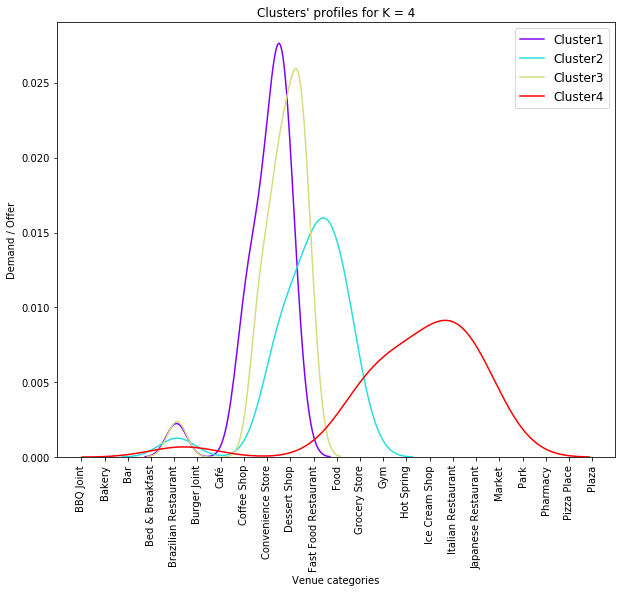

In [288]:
plt.figure(figsize=(10,8))

kclusters = 4
spcities_clusters = results_list[kclusters-3]
kmeans_labels = list(spcities_clusters['Cluster Labels'])

venues_vs_population.insert(0, 'Cluster Labels', kmeans_labels)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for i in range(kclusters):
    df = venues_vs_population[venues_vs_population['Cluster Labels'] == i]
    df_profile = df.sum()
    
    label = 'Cluster' + str(i+1)
    sns.distplot(df_profile.iloc[3:], rug=False, hist=False, kde=True, label=label, color=rainbow[i])

categories = list(df_profile.index)[3:]
ticks = np.arange(len(categories))*17-68
#print(categories)
#print(ticks)

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Clusters\' profiles for K = {}'.format(kclusters))
plt.xlabel('Venue categories')
plt.xticks(ticks=ticks, labels=categories, rotation='vertical')
plt.ylabel('Demand / Offer')
plt.savefig('finalDistribution.png')

venues_vs_population.drop('Cluster Labels', axis=1, inplace=True)

## 5. Results and Discussion <a name="discussion"></a>

Our analysis shows there is a high concentration of cluster 2 cities (green dots) closer to the coast and around the São Paulo city (the capital of SP state), and sparsed cities of the other 3 clusters. 
This is expected, because the cluster 2 is composed of bigger and more developed cities of SP state, which are concentrated closer to the capital. Also, if we observe the distribution graph, the cluster 2 shows lower relation between demand and offer of each kind of establishment, because although these cities have huge number of habitants, they also have almost every kind of products and services in high quantities.

However, the cluster 4 also shows low values of demand vs offer on distribution graph, and the cities of this cluster (red dots) are smaller and sparser on the map. These cities seem to have good diversity of venue categories and with enough availability to their population.

The remaining clusters, 1 and 2, consist of cities with some specific venue categories missing. These seems to be great candidate cities for entrepreneurship. The cities in cluster 1, for example, lack in convenience stores, while the cities in cluster 2 lacks in dessert shops.

## 6. Conclusion <a name="conclusion"></a>

The purpose of this project was to identify similar cities in terms of availability of venue categories in order to support stakeholders to find cities as best opportunities to endeavor their business.
By counting the number of each venue category in each city, we can find similar cities in terms of existence of these venues, but to understand better the opportunities we also considered the population of the cities. 
Taking the population into account, we could calculate the probable demand versus offert of each venue category in each city, and perform a better clustering of cities in terms of opportunities.

Furthermore, this analysis could also help people who wants to move to another city, keeping the life style and access to specific facilities.